# C++ Berry-INLA version

In [1]:
import sys
sys.path.append('../../research/berry/')
import util

import fast_inla
from scipy.special import logit, expit
import matplotlib.pyplot as plt
import numpy as np
from pykevlar import mt19937
from pykevlar.grid import HyperPlane, make_cartesian_grid_range
from pykevlar.driver import accumulate_process
import pykevlar.core.model.binomial

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
fi = fast_inla.FastINLA(2)

n_arms = 2
model_type_name = 'BerryINLA' + str(n_arms)
model_type = getattr(pykevlar.core.model.binomial, model_type_name)
print(model_type)
seed = 10
n_theta_1d = 16
sim_size = 1000
n_threads = 1

# define null hypos
null_hypos = []
for i in range(n_arms):
    n = np.zeros(n_arms)
    # null is:
    # theta_i <= logit(0.1)
    # the normal should point towards the negative direction. but that also
    # means we need to negate the logit(0.1) offset
    n[i] = -1
    null_hypos.append(HyperPlane(n, -logit(0.1)))

gr = make_cartesian_grid_range(n_theta_1d, np.full(n_arms, -3.5), np.full(n_arms, 1.0), sim_size)

<class 'pykevlar.core.model.binomial.BerryINLA2'>


Red dots are points in the alternative hypothesis space.
Blue dots are points in the null space.

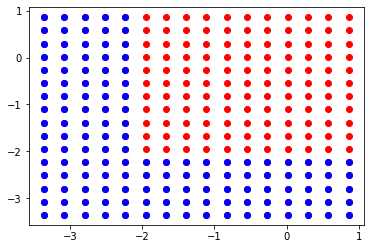

In [3]:
gr.create_tiles(null_hypos)
plt.plot(gr.thetas()[0,:], gr.thetas()[1,:], 'ro')
gr.prune()
plt.plot(gr.thetas()[0,:], gr.thetas()[1,:], 'bo')
plt.show()

Run a single example set of data and make sure that the kevlar model is producing the sample results as the prototype FastINLA code.

In [4]:
y = np.array([[4, 5]])
n = np.array([[35, 35]])
critical_values = [0.85] # final analysis exceedance requirement (note for interim analysis, the threshold)
b = model_type(
    n[0,0],
    critical_values,
    np.full(2, fi.thresh_theta),
    fi.sigma2_rule.wts.copy(),
    fi.cov.reshape((-1, 4)).T.copy(),
    fi.neg_precQ.reshape((-1, 4)).T.copy(),
    fi.logprecQdet.copy(),
    fi.log_prior.copy(),
    fi.tol,
    fi.logit_p1
)
correct = fi.numpy_inference(y, n)[1][0]
exc = b.get_posterior_exceedance_probs(y[0])
np.testing.assert_allclose(exc, correct)

In [5]:
import time
start = time.time()
out = accumulate_process(b, gr, sim_size, seed, n_threads)
end = time.time()
print('runtime', end - start)

runtime 4.177856922149658


In [6]:
theta = gr.thetas().T.copy()
theta_tiles = np.repeat(theta, np.array(gr.n_tiles_per_pt), axis=0)

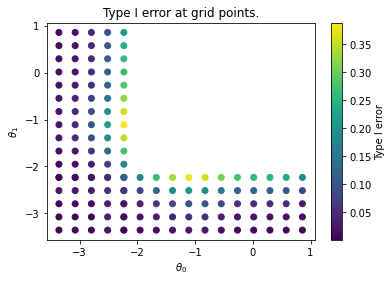

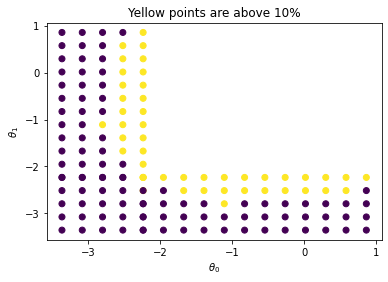

In [7]:
plt.figure()
plt.title('Type I error at grid points.')
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=out.typeI_sum()[0] / sim_size)
cbar = plt.colorbar()
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Type I error')
plt.show()
plt.title('Yellow points are above 10%')
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=out.typeI_sum()[0] / sim_size > 0.1)
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.show()

# Python re-implementation of accumulation

In the cell below, I generate random numbers using exactly the same mechanism as the C++ code. THIS WOULD BE UNNECESSARY in a normal situation where I'm not trying to exactly reproduce Kevlar accumulation results.

In [8]:
%%time

# Use the mt19937 object exported from C++ so that we can match the C++ random
# sequence exactly. This is not necessary in the long term but is temporarily
# useful to ensure that this code is producing identical output to the C++
# version.
n_arm_samples = 35
gen = mt19937(seed)

# We flip the order of n_arms and n_arm_samples here so the random number
# generator produces the same sequence of uniforms as are used in the C++ kevlar
# internals. The Kevlar function operates in column-major/Fortran order. Whereas
# here, numpy operates in row-major/C ordering b
samples = np.empty((sim_size, n_arms, n_arm_samples))
gen.uniform_sample(samples.ravel())
# after transposing, samples will have shape (sim_size, n_arm_samples, n_arms)
samples = np.transpose(samples, (0, 2, 1))

CPU times: user 6.3 ms, sys: 197 µs, total: 6.5 ms
Wall time: 6.48 ms


In [9]:
# In a normal situation, we can generate samples like this:
# np.random.seed(seed)
# samples = np.random.rand(sim_size, n_arm_samples, n_arms)

In [19]:
%%time
# Calculate exceedance from each simulated sample.
# 1. Calculate the binomial count data.
# 2. See the FastINLA module for details on the inference procedure.
# 3. Success is defined by whether the exceedance probability exceeds the
#    critical value

# The sufficient statistic for binomial is just the number of uniform draws
# above the threshold probability. But the `p` array has shape (n_thetas,
# n_arms). So, we add empty dimensions to broadcast to an output `y` array of
# shape: (n_thetas, sim_size, n_arm_samples, n_arms)
theta = gr.thetas().T.copy()
theta_tiles = np.repeat(theta, np.array(gr.n_tiles_per_pt), axis=0)
p_tiles = expit(theta_tiles)
y = np.sum(samples[None] < p_tiles[:, None, None, :], axis=2)

# FastINLA expects inputs of shape (n, n_arms) so we must flatten our 3D arrays.
# We reshape exceedance afterwards to bring it back to 3D (n_thetas, sim_size, n_arms)
# TODO: This is where we implement the early stopping procedure.
y_flat = y.reshape((-1, 2))
n_flat = np.full_like(y_flat, n_arm_samples)
_, exceedance_flat, _, _ = fi.jax_inference(y_flat, n_flat)
exceedance = exceedance_flat.reshape(y.shape)
# instead of success, "did we reject"
success = exceedance > critical_values[0]

CPU times: user 1.31 s, sys: 95.1 ms, total: 1.41 s
Wall time: 734 ms


In [35]:
%%time
# Determine type I error. 
# 1. type I is only possible when the null hypothesis is true. 
# 2. check all null hypotheses.
# 3. sum across all the simulations.
is_null_per_arm = np.array([[gr.check_null(i, j) for j in range(n_arms)] for i in range(p_tiles.shape[0])])
false_reject = success & is_null_per_arm[:, None,]
any_rejection = np.any(false_reject, axis=-1)
typeI_sum = any_rejection.sum(axis=-1)

CPU times: user 4.04 ms, sys: 1.15 ms, total: 5.19 ms
Wall time: 3.65 ms


In [40]:
y.size * 4 / 3e9 * 1000

0.38666666666666666

In [16]:
%%time
# The score function is the primary component of the typeI gradient:
# 1. for binomial, it's just: y - n * p
# 2. only summed when there is a rejection in the given simulation
score = y - n_arm_samples * p_tiles[:, None, :]
typeI_score = np.sum(any_rejection[:, :, None] * score, axis=1)

CPU times: user 2.91 ms, sys: 1.29 ms, total: 4.19 ms
Wall time: 2.89 ms


Confirm that Kevlar and this Python code produce the same output.

In [17]:
typeI_good = np.all(out.typeI_sum() == typeI_sum)
score_good = np.all(out.score_sum().reshape((-1, 2)) == typeI_score)
typeI_good, score_good

(True, True)

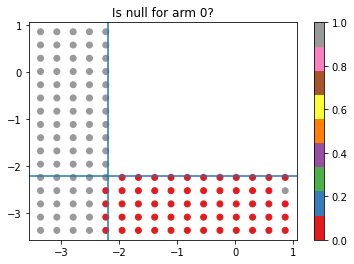

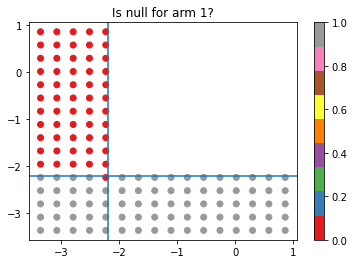

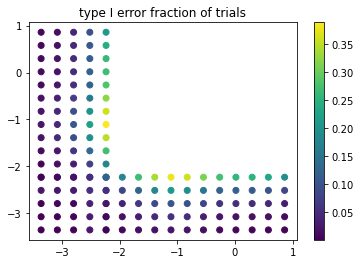

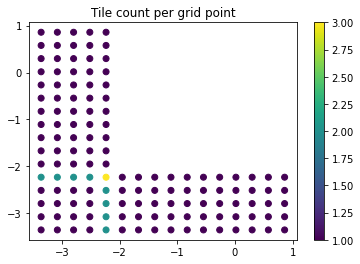

In [14]:
# y_avg = np.mean(y, axis=1)
# plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=y_avg[:,0] / n_arm_samples)
# plt.colorbar()
# plt.show()
# plt.title()
# plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=y_avg[:,1] / n_arm_samples)
# plt.colorbar()
# plt.show()
pos_start = np.cumsum(gr.n_tiles_per_pt) - gr.n_tiles_per_pt[0]
is_null_per_arm_gridpt = np.add.reduceat(is_null_per_arm, pos_start, axis=0) > 0

plt.title('Is null for arm 0?')
plt.scatter(theta[:,0], theta[:,1], c=is_null_per_arm_gridpt[:,0], cmap='Set1')
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.xlim(np.min(theta[:,0]) - 0.2, np.max(theta[:,0]) + 0.2)
plt.ylim(np.min(theta[:,1]) - 0.2, np.max(theta[:,1]) + 0.2)
plt.colorbar()
plt.show()
plt.title('Is null for arm 1?')
plt.scatter(theta[:,0], theta[:,1], c=is_null_per_arm_gridpt[:,1], cmap='Set1')
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.xlim(np.min(theta[:,0]) - 0.2, np.max(theta[:,0]) + 0.2)
plt.ylim(np.min(theta[:,1]) - 0.2, np.max(theta[:,1]) + 0.2)
plt.colorbar()
plt.show()

plt.title('type I error fraction of trials')
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=typeI_sum / sim_size)
plt.colorbar()
plt.show()

plt.title('Tile count per grid point')
plt.scatter(theta[:,0], theta[:,1], c=np.array(gr.n_tiles_per_pt))
plt.colorbar()
plt.show()

# Comparing against MCMC for a few grid points

This is a check to determine how much of the type I error is real versus an artifact coming from INLA.



In [15]:
import mcmc

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
sorted_idxs = np.argsort(typeI_sum)
idx = sorted_idxs[-1]
p_tiles[idx]

array([0.09670579, 0.24798743])

In [17]:
y_mcmc = y[idx, :]
n_mcmc = np.full((sim_size, n_arms), n_arm_samples)
data_mcmc = np.stack((y_mcmc, n_mcmc), axis=-1)
n_mcmc_sims = 1000
results_mcmc = mcmc.mcmc_berry(
    data_mcmc[:n_mcmc_sims], fi.logit_p1, np.full(n_mcmc_sims, fi.thresh_theta), n_arms=2
)
success_mcmc = results_mcmc["exceedance"] > critical_values[0]

In [23]:
import pickle
with open(f'berry_kevlar_mcmc{idx}.pkl', 'wb') as f:
    pickle.dump(results_mcmc, f)

{'cilow': array([[-1.55425224, -0.90182134],
        [-2.58764885, -0.87878222],
        [-2.15149666, -1.49389695],
        ...,
        [-4.87450234, -0.71380409],
        [-1.77003004, -1.40768917],
        [-1.90773142, -1.78885146]]),
 'cihi': array([[ 0.12805984,  0.56372449],
        [-0.044032  ,  0.76144898],
        [-0.26016351,  0.02220237],
        ...,
        [-0.63665309,  0.84042056],
        [-0.09862785,  0.06431795],
        [-0.29905608, -0.20029741]]),
 'theta_map': array([[-0.64332412, -0.24102848],
        [-1.28906353, -0.00924829],
        [-1.09935896, -0.74448613],
        ...,
        [-2.71646145,  0.10486362],
        [-0.90733577, -0.6544497 ],
        [-1.09521201, -0.99619256]]),
 'exceedance': array([[0.9316, 0.9999],
        [0.5677, 0.9996],
        [0.7387, 0.9373],
        ...,
        [0.083 , 0.9999],
        [0.8548, 0.9682],
        [0.735 , 0.8088]]),
 'x': [{'mu': DeviceArray([[-1.11260699, -1.33799339, -1.38780192, ..., -0.14733239,
       

In [20]:
mcmc_typeI = np.sum(np.any(success_mcmc & is_null_per_arm[idx, None,:], axis=-1), axis=-1)
inla_typeI = typeI_sum[idx]
mcmc_typeI, inla_typeI

(335, 388)

In [22]:
bad_sim_idxs = np.where(
    np.any((success[idx] & (~success_mcmc)) & is_null_per_arm[idx, None], axis=-1)
)[0]
unique_bad = np.unique(y[idx, bad_sim_idxs], axis=0)
print("theta =", theta_tiles[idx])
bad_count = 0
for i in range(unique_bad.shape[0]):
    y_bad = unique_bad[i]
    other_sim_idx = np.where((y[idx, :, 0] == y_bad[0]) & (y[idx, :, 1] == y_bad[1]))[0]
    pct_mcmc = (
        np.any(
            success_mcmc[other_sim_idx] & is_null_per_arm[idx, None, :], axis=-1
        ).sum()
        / other_sim_idx.shape[0]
    )
    if pct_mcmc < 0.2:
        print("bad y =", y_bad, "count =", other_sim_idx.shape[0])
        bad_count += other_sim_idx.shape[0]
print("\ninla type I =", inla_typeI)
print("bad type I count =", bad_count)
print('"true" type I count =', inla_typeI - bad_count)
# print('pct of mcmc sims that had type I error', pct_mcmc)
# print('')

# print(
#     "unique y where INLA says type 1 but MCMC says not type 1: ",
#     np.unique(y[idx, bad_sim_idxs], axis=0),
# )


theta = [-2.234375 -1.109375]
bad y = [6 4] count = 2

inla type I = 388
bad type I count = 2
"true" type I count = 386


In [63]:
bad_sim_idxs = np.where(np.any((success[idx] & (success_mcmc)) & is_null_per_arm[idx, None], axis=-1))[0]
print('theta: ', theta_tiles[idx])
print('unique y where INLA says type 1 and MCMC also says type 1: ', np.unique(y[idx, bad_sim_idxs], axis=0))

theta:  [-2.234375 -1.109375]
unique y where INLA says type 1 and MCMC also says type 1:  [[ 4  7]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 4 11]
 [ 5  6]
 [ 5  7]
 [ 5  8]
 [ 5  9]
 [ 5 10]
 [ 5 11]
 [ 5 12]
 [ 5 13]
 [ 5 14]
 [ 5 15]
 [ 5 16]
 [ 6  4]
 [ 6  5]
 [ 6  6]
 [ 6  7]
 [ 6  8]
 [ 6  9]
 [ 6 10]
 [ 6 11]
 [ 6 12]
 [ 6 13]
 [ 6 15]
 [ 6 16]
 [ 6 19]
 [ 7  4]
 [ 7  5]
 [ 7  6]
 [ 7  7]
 [ 7  8]
 [ 7  9]
 [ 7 10]
 [ 7 11]
 [ 7 12]
 [ 7 13]
 [ 7 14]
 [ 7 15]
 [ 8  3]
 [ 8  6]
 [ 8  7]
 [ 8  8]
 [ 8  9]
 [ 8 11]
 [ 9  6]
 [ 9  9]
 [ 9 10]
 [10  7]]


In [64]:

bad_sim_idxs = np.where(np.any((~success[idx] & (~success_mcmc)) & is_null_per_arm[idx, None], axis=-1))[0]
print('theta: ', theta_tiles[idx])
print('unique y where INLA says type 1 and MCMC also says type 1: ', np.unique(y[idx, bad_sim_idxs], axis=0))

theta:  [-2.234375 -1.109375]
unique y where INLA says type 1 and MCMC also says type 1:  [[ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 2 11]
 [ 2 12]
 [ 2 13]
 [ 2 14]
 [ 2 15]
 [ 2 16]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 3 11]
 [ 3 12]
 [ 3 13]
 [ 3 14]
 [ 3 15]
 [ 3 16]
 [ 3 17]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 4  6]
 [ 4 12]
 [ 4 13]
 [ 4 14]
 [ 4 16]
 [ 5  3]
 [ 5  4]]


# [work-in-progress] Trying to set up a Python Kevlar Model.

The barrier here is that I need to work through the pybind11 layer and add trampoline functions that allow us to implement virtual functions in Python. https://pybind11.readthedocs.io/en/stable/advanced/classes.html

In [1]:
import sys
sys.path.append('../../research/berry/')

In [2]:
import fast_inla
import numpy as np

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [17]:
from pykevlar.core.model import ModelBase, SimGlobalStateBase, SimStateBase
from pykevlar.core.model.binomial import SimpleSelection, SimpleSelectionSimGlobalState, SimpleSelectionSimState


class KevlarBerryINLA(SimpleSelection):
    def __init__(self, n_arms, n_arm_samples, gr):
        super().__init__(n_arms, n_arm_samples, 0, [2.1])
        # self.critical_values([2.1])
        self.gr = gr

class SGS(SimGlobalStateBase):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def make_sim_state(self):
        print("making sim state")
        return SS(self.model)

class SS(SimStateBase):
    def __init__(self, model):
        self.model = model

    def simulate(self, gen, rej_len):
        print(gen, rej_len)
        return None


class BS(SimpleSelectionSimState):
    pass

In [19]:
SimpleSelectionSimState()

TypeError: pykevlar.core.model.binomial.SimpleSelectionSimState: No constructor defined!

In [12]:
n_arms = 2
arm_samples = 35
n_sims = 10
seed = 10

In [13]:
from pykevlar.grid import HyperPlane

# define null hypos
null_hypos = []
for i in range(1, n_arms):
    n = np.zeros(n_arms)
    n[0] = 1
    n[i] = -1
    null_hypos.append(HyperPlane(n, 0))

from utils import make_cartesian_grid_range

gr = make_cartesian_grid_range(3, np.full(n_arms, -0.5), np.full(n_arms, 0.5), 1000)
gr.create_tiles(null_hypos)
gr.prune()

In [14]:
from pykevlar.core.driver import accumulate
from pykevlar.core.bound import TypeIErrorAccum
model = KevlarBerryINLA(n_arms, arm_samples, gr)
sgs = SGS(model)

In [15]:
# prepare output
acc_o = TypeIErrorAccum(
    model.n_models(),
    gr.n_tiles(),
    gr.n_params()
)

model.simulate()
acc_o.update(rej_len, )